# MORO Post-Analysis

Group 11, *EPA1361 Model-based Decision-making 18/19*

A. Werntges, H. Cheng, G. Papazotos, R. Patel, P. De Biase

**NOTE: While importing, it is important that both `problem_formulation_analysis.py` and `problem_formulation.py` are loaded since we changed the objectives of model.**

In [290]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import functools
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           IntegerParameter, Constant,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)

from model.problem_formulation import get_model_for_problem_formulation
from model.problem_formulation_analysis import get_model_for_problem_formulation_anslysis
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

## 1 – Performance of 9 policies selected out of MORO results

In [3]:
# load data of the policies with highest score in robustness metric for deaths
# perform experiments under these policies 
moro_results = pd.read_csv("./results/archive17500noEWS9best.csv")
moro_results.drop(moro_results.columns[0], axis=1, inplace=True) # drop irrelevant column

# subset the levers, create policy instance
moro_levers = moro_results.loc[:, [l.name for l in dike_model.levers]]

policies = []
for i in moro_levers.index:
    lever = moro_levers.iloc[i].to_dict()
    policies.append(Policy('policy {}'.format(i+1), **lever))

In [4]:
'''LOAD RESULTS FROM 
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=2000, policies=policies)
'''
results = load_results('results/MORO_post_no_constraints.tar.gz')

experiment, outcomes = results
results_df = pd.concat([experiment['policy'],
                        pd.DataFrame.from_dict(outcomes)], axis=1)

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\MORO_post_no_constraints.tar.gz


In [5]:
results_df.head()

,policy,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,...,A.3_Dike Investment Costs 1,A.3_Expected Number of Deaths 1,A.4_Expected Annual Damage 1,A.4_Dike Investment Costs 1,A.4_Expected Number of Deaths 1,A.5_Expected Annual Damage 1,A.5_Dike Investment Costs 1,A.5_Expected Number of Deaths 1,RfR Total Costs 1,Expected Evacuation Costs 1
0,policy1,0.0,8.526436e+07,0.0,0.0,9.952540e+07,0.0,0.0,4.060905e+07,0.0,...,0,0.0,0.0,8.844943e+06,0.0,0.0,4.670590e+07,0.0,151900000.0,0.0
1,policy1,0.0,8.526436e+07,0.0,0.0,9.952540e+07,0.0,0.0,4.060905e+07,0.0,...,0,0.0,0.0,8.844943e+06,0.0,0.0,4.670590e+07,0.0,151900000.0,0.0
2,policy1,0.0,8.526436e+07,0.0,0.0,9.952540e+07,0.0,0.0,4.060905e+07,0.0,...,0,0.0,0.0,8.844943e+06,0.0,0.0,4.670590e+07,0.0,151900000.0,0.0
3,policy1,0.0,8.526436e+07,0.0,0.0,9.952540e+07,0.0,0.0,4.060905e+07,0.0,...,0,0.0,0.0,8.844943e+06,0.0,0.0,4.670590e+07,0.0,151900000.0,0.0
4,policy1,0.0,8.526436e+07,0.0,0.0,9.952540e+07,0.0,0.0,4.060905e+07,0.0,...,0,0.0,0.0,8.844943e+06,0.0,0.0,4.670590e+07,0.0,151900000.0,0.0


In [6]:
## get the aggregated mean values for disaggregated outcomes for damage and deaths over timesteps

# create a dict for names of aggregated outcomes
agg_results = {}
for kpi in results_df.columns:
    if 'Damage' in kpi or 'Deaths' in kpi:
        key = kpi.rsplit(' ', 1)[0] # remove the suffix of timestep
        if not key in agg_results.keys():
            agg_results.update({key: [kpi]})
        else:
            agg_results.update({key: agg_results[key]+[kpi]})
            
# get the aggregated mean values
for key in agg_results:
    results_df[key] = results_df.loc[:, agg_results[key]].mean(axis=1)

In [45]:
# the robustness metrics functions for deaths and damage
def threshold(threshold, data):
    '''Find fraction which is below the specified threshold
    Paramter
    --------
    threshold : speified threshold of the outcome
    data : input array of outcome
    '''
    return np.sum(data<=threshold)/len(data)

death_funcs = functools.partial(threshold, 0.000002)
damage_funcs = functools.partial(threshold, 20000)

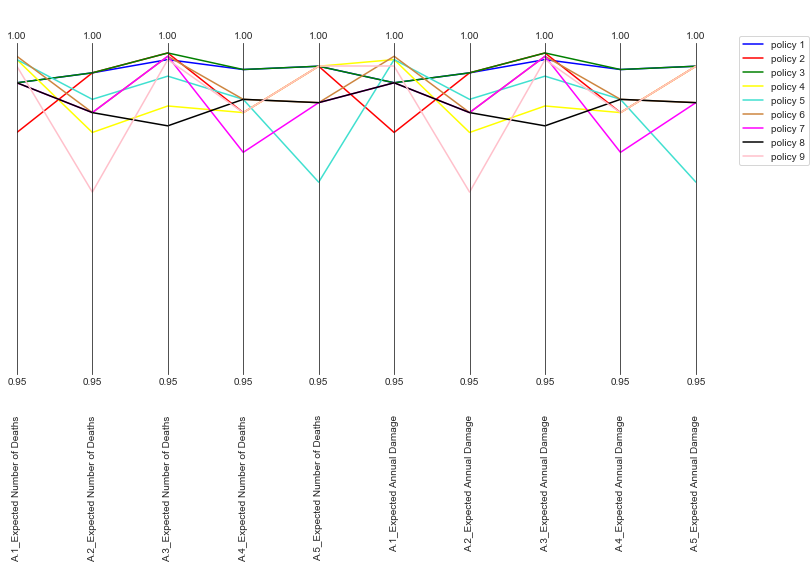

In [72]:
# outcomes to make parallel coordinate plot
objectives = agg_results.keys()

# tranform the outcomes to robustness metrics
robustness_per_obj = {}
for obj in objectives: # per outcome
    robustness_policies = []
    for policy in results_df.policy.unique(): # per policy
        raw = results_df.loc[results_df.policy == policy, obj] # subset the results
        robustness = [death_funcs(raw) if 'Expected Number of Deaths' in obj 
                      else damage_funcs(raw)]
        robustness_policies.append(*robustness)
    robustness_per_obj.update({obj: robustness_policies})

# create robustness df, sort the columns with deaths at the front
robustness_df = pd.DataFrame.from_dict(robustness_per_obj)
robustness_df = robustness_df[sorted(robustness_df.columns, 
                                     key = lambda x: 0 if 'Deaths' in x else 1)]

# set limits for parcoords plot
limits = pd.DataFrame(np.repeat([0.95, 1], len(objectives)).reshape(2, len(objectives)),
                      columns = robustness_df.columns.tolist())

# plot parcoords plot
colors = ['blue','red','green','yellow','turquoise',
          'peru','magenta','black','pink'] # random color per policy
ax = parcoords.ParallelAxes(limits, fontsize=10)
for i in range(len(robustness_df)):
    ax.plot(robustness_df.iloc[i].to_frame().T, 
            label='policy {}'.format(i+1),
            color=colors[i])
ax.fig.set_size_inches(10, 8)
ax.legend()

### *Boxplot*

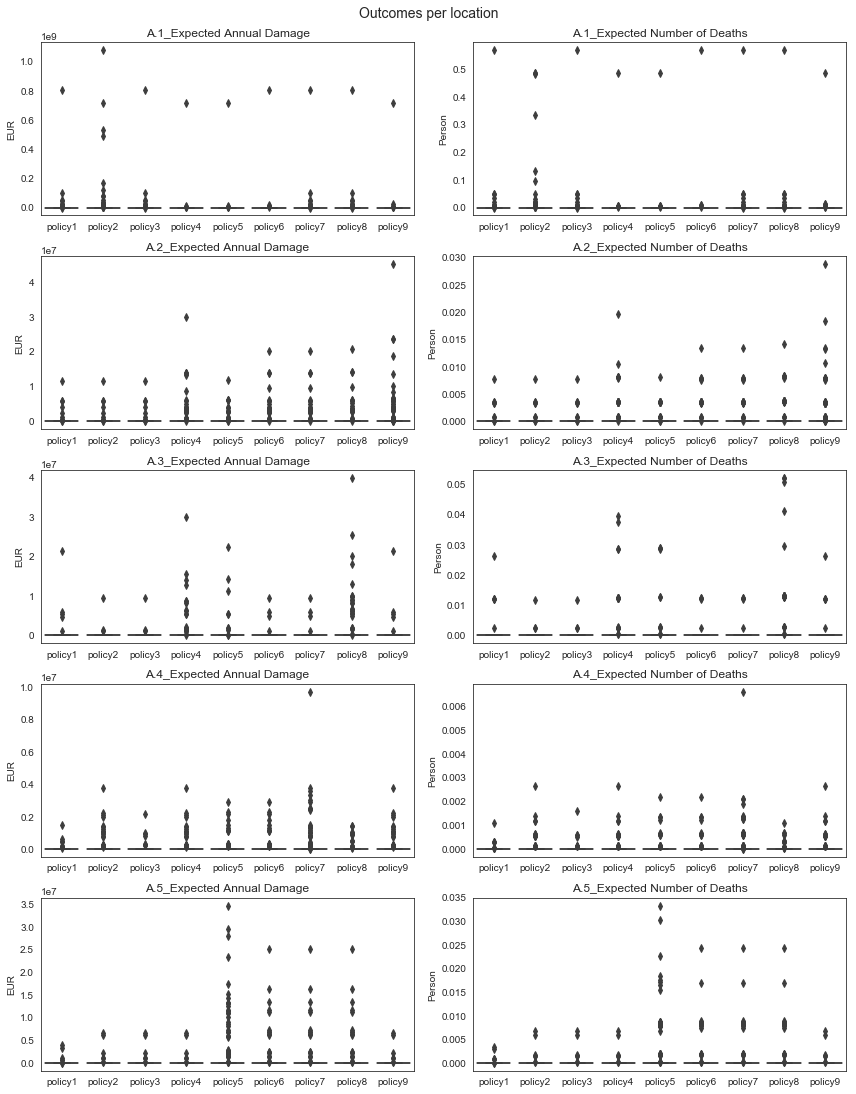

In [149]:
# create datatframe with only outcomes aggregated over time
results_agg = results_df.loc[:, ['policy']+list(agg_results.keys())]

# make boxplots for each outcome
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
subplots_i = np.arange(10).reshape(5, 2)

for ii, key in enumerate(agg_results.keys()): # per outcome
    i, j = np.where(subplots_i == ii)
    sns.boxplot(data=results_agg, x='policy', y=key, 
                ax=axes[int(i), int(j)])
    axes[int(i), int(j)].set_title(key)
    axes[int(i), int(j)].set_xlabel('')
    if 'Deaths' in key:
        axes[int(i), int(j)].set_ylabel('Person')
    else:
        axes[int(i), int(j)].set_ylabel('EUR')

fig.suptitle('Outcomes per location', y=1.01, fontsize=14)
plt.tight_layout()

## 2 – Performance of 9 Policies when all political constraints are applied

In this step in the 9 policies chosen from the results of MORO, the following political constraints will be applied:

- No room for the river in places rural places.
- Reduce dike heightening at A4 to 5 dm and at A5 to 3 dm.
- If dike heightening implemented in first step without rfr in a location, no rfr can be implemented in that location in time steps 2.

In [152]:
# load data of the policies with highest score in robustness metric for deaths
# perform experiments under these policies 
moro_results = pd.read_csv("./results/archive17500noEWS9best.csv")
moro_results.drop(moro_results.columns[0], axis=1, inplace=True) # drop irrelevant column

# apply all political constraints
moro_results['A.4_DikeIncrease 0'] = 5 # limit dike increase to A4 5 dm
moro_results['A.5_DikeIncrease 0'] = 3 # limit dike increase to A5 3 dm
moro_results['0_RfR 0'] = 0 # No RfR in rural areas (A1, A2, A4)
moro_results['0_RfR 1'] = 0 
moro_results['1_RfR 0'] = 0
moro_results['1_RfR 1'] = 0
moro_results['3_RfR 0'] = 0
moro_results['3_RfR 1'] = 0

# subset the levers, create policy instance
moro_levers = moro_results.loc[:, [l.name for l in dike_model.levers]]

policies = []
for i in moro_levers.index:
    lever = moro_levers.iloc[i].to_dict()
    policies.append(Policy('policy {}'.format(i+1), **lever))

In [153]:
'''LOAD RESULTS FROM
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=2000, policies=policies)
#
'''
results = load_results('./results/MORO_post_all_constraints.tar.gz')

experiment, outcomes = results
results_df = pd.concat([experiment['policy'],
                        pd.DataFrame.from_dict(outcomes)], axis=1)

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\MORO_post_all_constraints.tar.gz


In [154]:
## get the aggregated mean values for disaggregated outcomes for damage and deaths over timesteps

# create a dict for names of aggregated outcomes
agg_results = {}
for kpi in results_df.columns:
    if 'Damage' in kpi or 'Deaths' in kpi:
        key = kpi.rsplit(' ', 1)[0] # remove the suffix of timestep
        if not key in agg_results.keys():
            agg_results.update({key: [kpi]})
        else:
            agg_results.update({key: agg_results[key]+[kpi]})
            
# get the aggregated mean values
for key in agg_results:
    results_df[key] = results_df.loc[:, agg_results[key]].mean(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


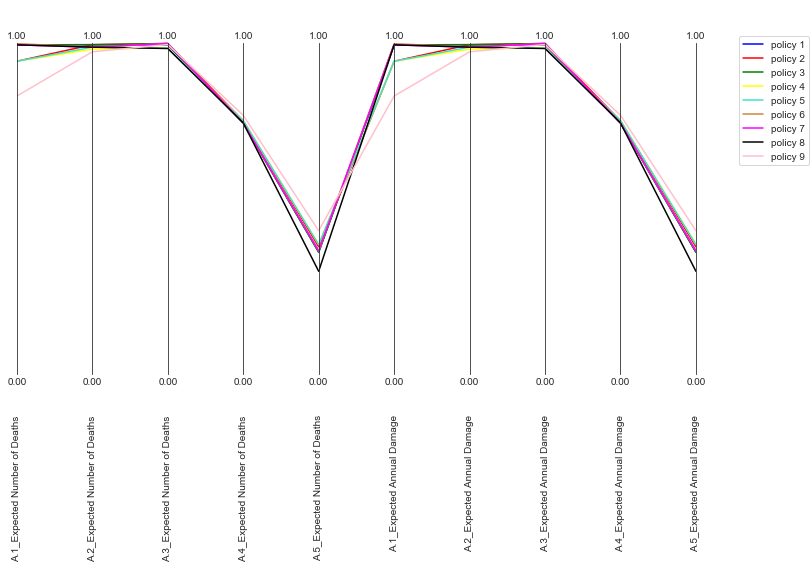

In [156]:
# outcomes to make parallel coordinate plot
objectives = agg_results.keys()

# tranform the outcomes to robustness metrics
robustness_per_obj = {}
for obj in objectives: # per outcome
    robustness_policies = []
    for policy in results_df.policy.unique(): # per policy
        raw = results_df.loc[results_df.policy == policy, obj] # subset the results
        robustness = [death_funcs(raw) if 'Expected Number of Deaths' in obj 
                      else damage_funcs(raw)]
        robustness_policies.append(*robustness)
    robustness_per_obj.update({obj: robustness_policies})

# create robustness df, sort the columns with deaths at the front
robustness_df = pd.DataFrame.from_dict(robustness_per_obj)
robustness_df = robustness_df[sorted(robustness_df.columns, 
                                     key = lambda x: 0 if 'Deaths' in x else 1)]

# set limits for parcoords plot
limits = pd.DataFrame(np.repeat([0, 1], len(objectives)).reshape(2, len(objectives)),
                      columns = robustness_df.columns.tolist())

# plot parcoords plot
colors = ['blue','red','green','yellow','turquoise',
          'peru','magenta','black','pink'] # random color per policy
ax = parcoords.ParallelAxes(limits, fontsize=10)
for i in range(len(robustness_df)):
    ax.plot(robustness_df.iloc[i].to_frame().T, 
            label='policy {}'.format(i+1),
            color=colors[i])
ax.fig.set_size_inches(10, 8)
ax.legend()

### *Boxplots*

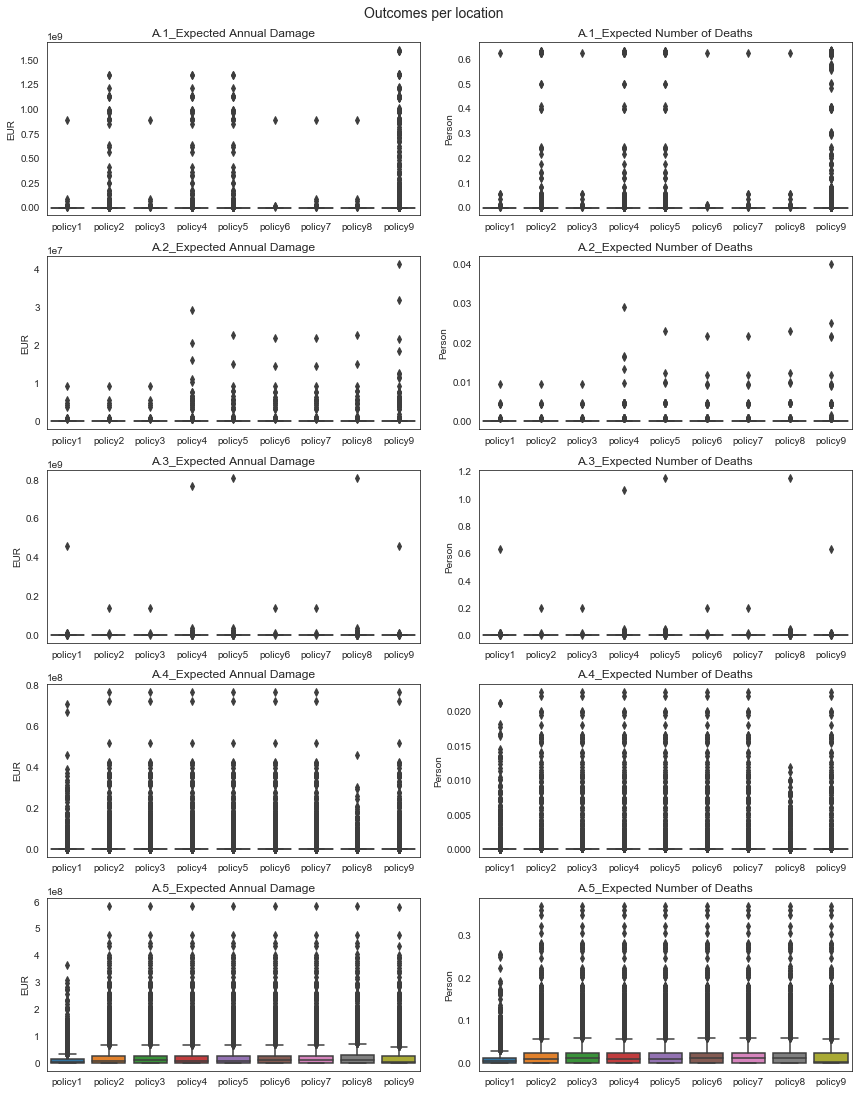

In [157]:
# create datatframe with only outcomes aggregated over time
results_agg = results_df.loc[:, ['policy']+list(agg_results.keys())]

# make boxplots for each outcome
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
subplots_i = np.arange(10).reshape(5, 2)

for ii, key in enumerate(agg_results.keys()): # per outcome
    i, j = np.where(subplots_i == ii)
    sns.boxplot(data=results_agg, x='policy', y=key, 
                ax=axes[int(i), int(j)])
    axes[int(i), int(j)].set_title(key)
    axes[int(i), int(j)].set_xlabel('')
    if 'Deaths' in key:
        axes[int(i), int(j)].set_ylabel('Person')
    else:
        axes[int(i), int(j)].set_ylabel('EUR')

fig.suptitle('Outcomes per location', y=1.01, fontsize=14)
plt.tight_layout()

## 3 – Performance of 9 policies with partial political constraints applied

Relax the following political constraints:
- Increase dike heightening in locations A4 and A5 to 7 dm and 6 dm respectively.
- Implement room for the river in location A4.

In [158]:
# load data of the policies with highest score in robustness metric for deaths
# perform experiments under these policies 
moro_results = pd.read_csv("./results/archive17500noEWS9best.csv")
moro_results.drop(moro_results.columns[0], axis=1, inplace=True) # drop irrelevant column

# apply partial political constraints
moro_results['A.4_DikeIncrease 0'] = 7 # relax dike increase to A4 7 dm
moro_results['A.5_DikeIncrease 0'] = 6 # relax dike increase to A5 6 dm
moro_results['0_RfR 0'] = 0 # No RfR in rural areas (A1, A2)
moro_results['0_RfR 1'] = 0 
moro_results['1_RfR 0'] = 0
moro_results['1_RfR 1'] = 0
#moro_results['3_RfR 0'] = 0 # Allow RfR at timestep1 in A4
moro_results['3_RfR 1'] = 0

# subset the levers, create policy instance
moro_levers = moro_results.loc[:, [l.name for l in dike_model.levers]]

policies = []
for i in moro_levers.index:
    lever = moro_levers.iloc[i].to_dict()
    policies.append(Policy('policy {}'.format(i+1), **lever))

In [159]:
'''LOAD RESULTS FROM
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=2000, policies=policies)
#
'''
results = load_results('results/MORO_post_partial_constraints.tar.gz')

experiment, outcomes = results
results_df = pd.concat([experiment['policy'],
                        pd.DataFrame.from_dict(outcomes)], axis=1)

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\MORO_post_partial_constraints.tar.gz


In [160]:
## get the aggregated mean values for disaggregated outcomes for damage and deaths over timesteps

# create a dict for names of aggregated outcomes
agg_results = {}
for kpi in results_df.columns:
    if 'Damage' in kpi or 'Deaths' in kpi:
        key = kpi.rsplit(' ', 1)[0] # remove the suffix of timestep
        if not key in agg_results.keys():
            agg_results.update({key: [kpi]})
        else:
            agg_results.update({key: agg_results[key]+[kpi]})
            
# get the aggregated mean values
for key in agg_results:
    results_df[key] = results_df.loc[:, agg_results[key]].mean(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


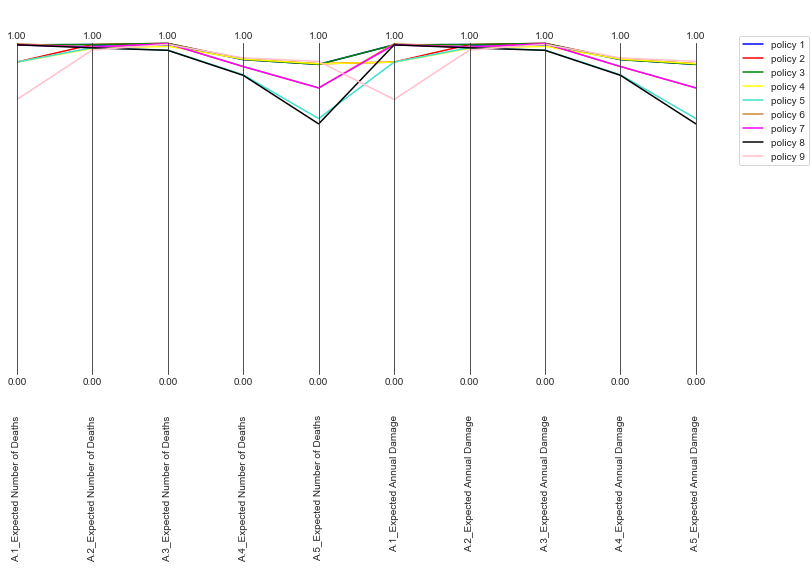

In [166]:
# outcomes to make parallel coordinate plot
objectives = agg_results.keys()

# tranform the outcomes to robustness metrics
robustness_per_obj = {}
for obj in objectives: # per outcome
    robustness_policies = []
    for policy in results_df.policy.unique(): # per policy
        raw = results_df.loc[results_df.policy == policy, obj] # subset the results
        robustness = [death_funcs(raw) if 'Expected Number of Deaths' in obj 
                      else damage_funcs(raw)]
        robustness_policies.append(*robustness)
    robustness_per_obj.update({obj: robustness_policies})

# create robustness df, sort the columns with deaths at the front
robustness_df = pd.DataFrame.from_dict(robustness_per_obj)
robustness_df = robustness_df[sorted(robustness_df.columns, 
                                     key = lambda x: 0 if 'Deaths' in x else 1)]

# set limits for parcoords plot
limits = pd.DataFrame(np.repeat([0, 1], len(objectives)).reshape(2, len(objectives)),
                      columns = robustness_df.columns.tolist())

# plot parcoords plot
colors = ['blue','red','green','yellow','turquoise',
          'peru','magenta','black','pink'] # random color per policy
ax = parcoords.ParallelAxes(limits, fontsize=10)
for i in range(len(robustness_df)):
    ax.plot(robustness_df.iloc[i].to_frame().T, 
            label='policy {}'.format(i+1),
            color=colors[i])
ax.fig.set_size_inches(10, 8)
ax.legend()

### *Boxplots*

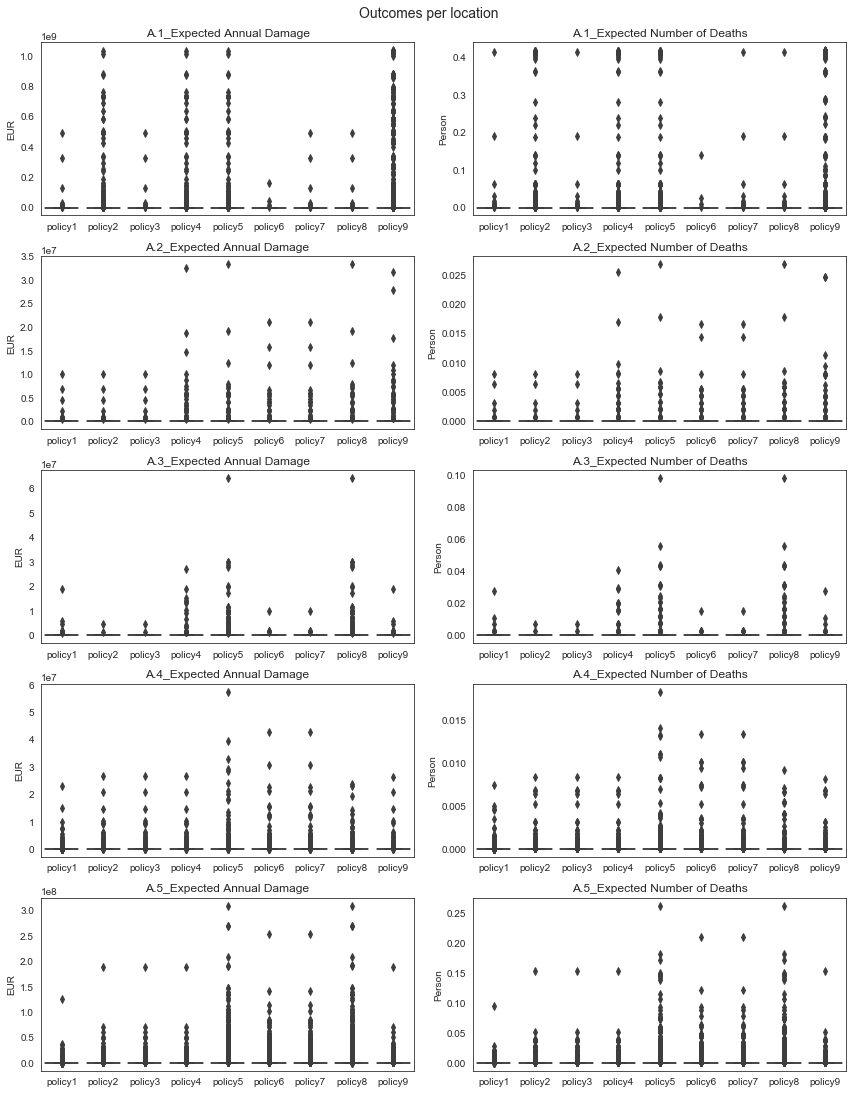

In [162]:
# create datatframe with only outcomes aggregated over time
results_agg = results_df.loc[:, ['policy']+list(agg_results.keys())]

# make boxplots for each outcome
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
subplots_i = np.arange(10).reshape(5, 2)

for ii, key in enumerate(agg_results.keys()): # per outcome
    i, j = np.where(subplots_i == ii)
    sns.boxplot(data=results_agg, x='policy', y=key, 
                ax=axes[int(i), int(j)])
    axes[int(i), int(j)].set_title(key)
    axes[int(i), int(j)].set_xlabel('')
    if 'Deaths' in key:
        axes[int(i), int(j)].set_ylabel('Person')
    else:
        axes[int(i), int(j)].set_ylabel('EUR')

fig.suptitle('Outcomes per location', y=1.01, fontsize=14)
plt.tight_layout()

### *Pairwise scatterplots*

For selected policy *policy3*, plot pairwise scatterplots for damage and deaths.

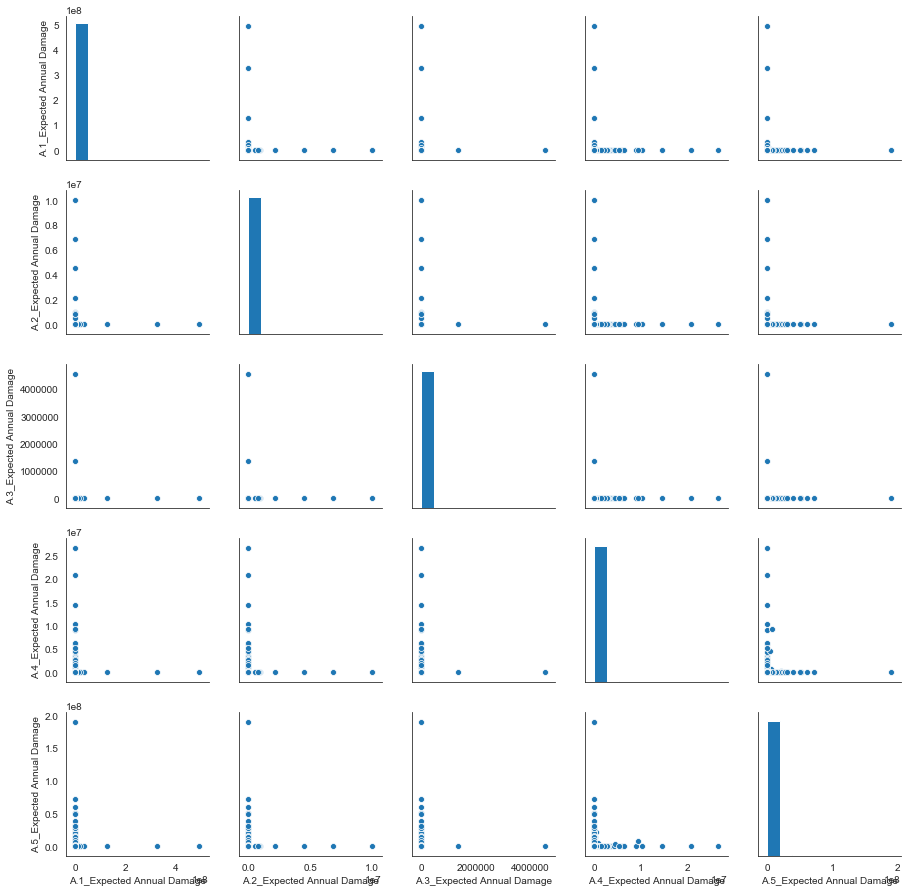

In [198]:
SELECTED_POLICY = 'policy3'

# subset the outcomes for selected policy
outcome_ll = results_agg.loc[results_agg['policy'] == SELECTED_POLICY]

# plot for damage
sns.pairplot(outcome_ll.loc[:, [col for col in outcome_ll.columns 
                                if 'Damage' in col]], diag_kind='hist')

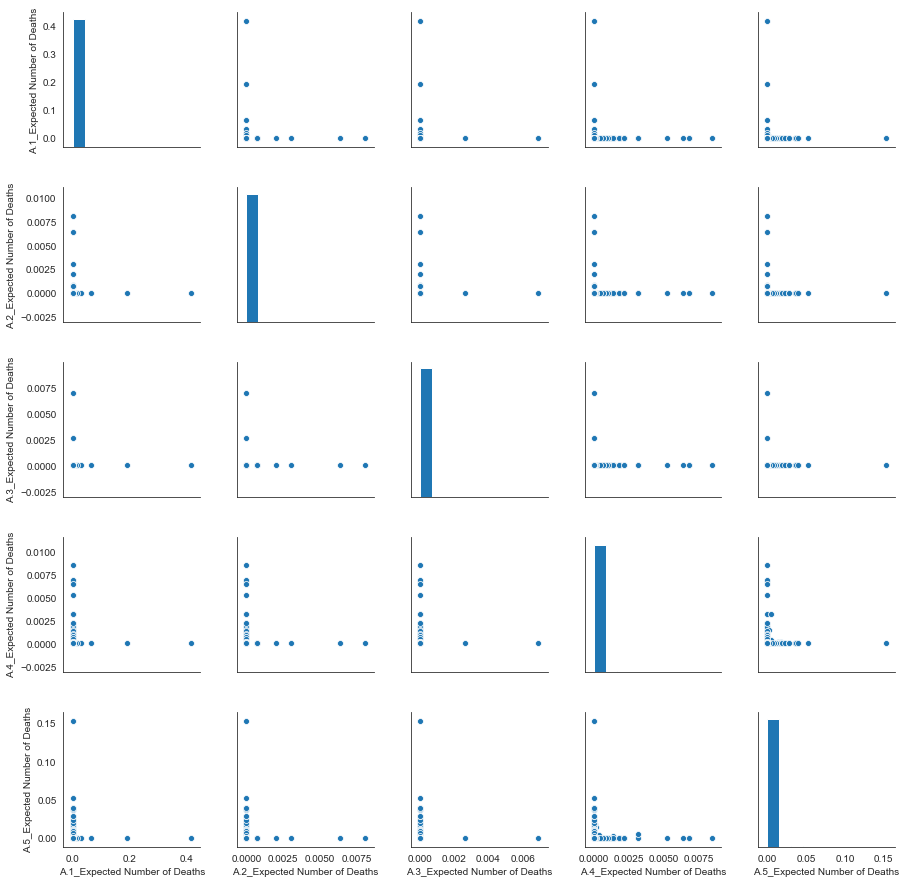

In [199]:
# plot for deaths
sns.pairplot(outcome_ll.loc[:, [col for col in outcome_ll.columns 
                                if 'Deaths' in col]], diag_kind='hist')

## 4 – Subspace partitioning and scenario discovery

### *Subspace partitioning for any failure*

In [247]:
def check_failure(df, THRESHOLD_DEATHS = 0, THRESHOLD_DAMAGE = 20000):
    '''
    Parameters
    ----------
    df : outcomes dataframe for a policy under a scenario
    THRESHOLD_DEATHS : specified threshold for deaths, default 0 person
    THRESHOLD_DAMAGE : specified threshold for damage, default 20,000 EUR
    
    Return
    ------
    True : failure, either (or both) deaths or damage exceeds threshold
    False: success
    '''
    deaths = (df.filter(regex='Deaths$') > THRESHOLD_DEATHS).any(axis=1) # if deaths exceed threshold
    damage = (df.filter(regex='Damage$') > THRESHOLD_DAMAGE).any(axis=1) # if damage exceed threshold
    
    failure = (deaths|damage) # fail if either deahts or damage exceed threshold
    
    return failure

In [255]:
SELECTED_POLICY = 'policy3'

# subset the outcomes for selected policy
outcome_ll = results_agg.loc[results_agg['policy'] == SELECTED_POLICY]

# check for the specified policy, if failure occurs at a scenario
if_fail_ll = check_failure(outcome_ll)

print('Check if the selected policy "{}" fails: \t{}'.format(SELECTED_POLICY, if_fail_ll.any()))

Check if the selected policy "policy3" fails: 	True


In [263]:
## apply PRIM and dimensional stacking to the policy to identify the cause of failure

# subset the uncertainties for the selected policy
experiment_ll = experiment.loc[experiment['policy'] == SELECTED_POLICY, 
                               [u.name for u in dike_model.uncertainties]]

x = experiment_ll.reset_index(drop=True)
y = if_fail_ll.reset_index(drop=True)

[MainProcess/INFO] 2000 points remaining, containing 245 cases of interest
[MainProcess/INFO] mean: 0.9603960396039604, mass: 0.0505, coverage: 0.39591836734693875, density: 0.9603960396039604 restricted_dimensions: 1


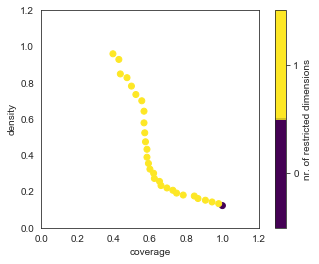

In [265]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.1, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

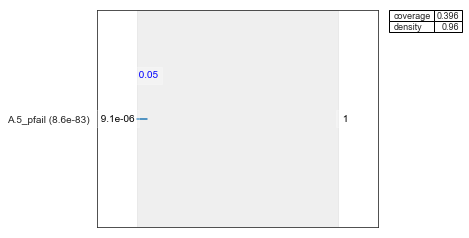

In [266]:
box1.inspect(style='graph')
plt.show()

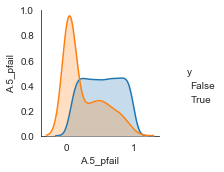

In [269]:
box1.show_pairs_scatter()
plt.show()

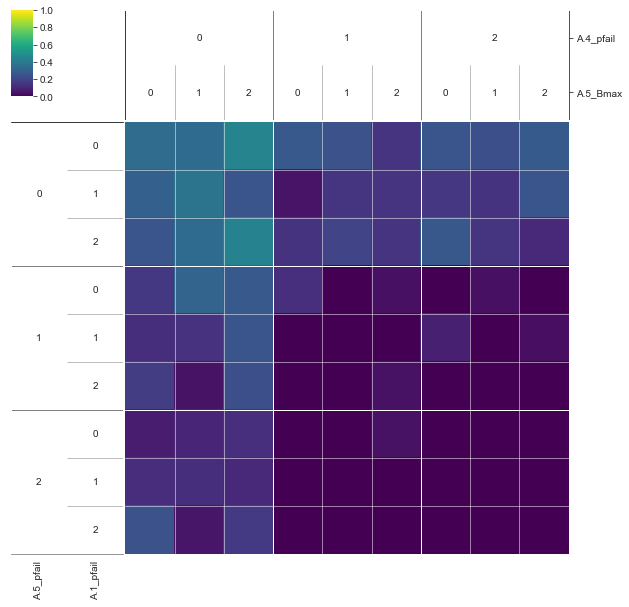

In [270]:
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

### *Subspace partitioning for dike failure at A4*

In [274]:
def check_failure_A4damage(df, THRESHOLD_DAMAGE = 20000):
    '''
    Parameters
    ----------
    df : outcomes dataframe for a policy under a scenario
    THRESHOLD_DAMAGE : specified threshold for damage, default 20,000 EUR
    
    Return
    ------
    True : failure, if any damage at A4 exceeds threshold
    False: success
    '''
    failure = (df['A.4_Expected Annual Damage'] > THRESHOLD_DAMAGE) # if damage exceed threshold
    
    return failure

In [275]:
SELECTED_POLICY = 'policy3'

# subset the outcomes for selected policy
outcome_ll = results_agg.loc[results_agg['policy'] == SELECTED_POLICY]

# check for the specified policy, if failure occurs at a scenario
if_fail_A4_ll = check_failure_A4damage(outcome_ll)

print('Check if the selected policy "{}" fails: \t{}'.format(SELECTED_POLICY, if_fail_A4_ll.any()))

Check if the selected policy "policy3" fails: 	True


In [277]:
## apply PRIM and dimensional stacking to the policy to identify the cause of failure

# subset the uncertainties for the selected policy
experiment_ll = experiment.loc[experiment['policy'] == SELECTED_POLICY, 
                               [u.name for u in dike_model.uncertainties]]

x = experiment_ll.reset_index(drop=True)
y = if_fail_A4_ll.reset_index(drop=True)

[MainProcess/INFO] 2000 points remaining, containing 100 cases of interest
[MainProcess/INFO] mean: 0.9108910891089109, mass: 0.0505, coverage: 0.92, density: 0.9108910891089109 restricted_dimensions: 1


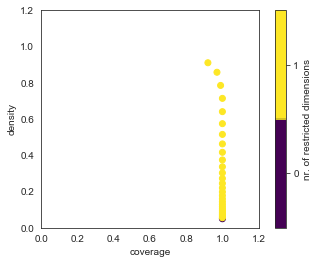

In [278]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.1, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

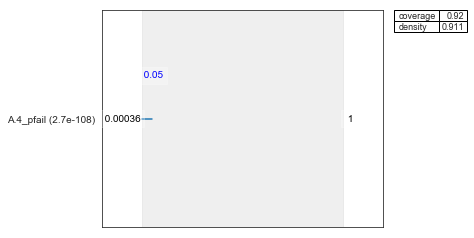

In [279]:
box1.inspect(style='graph')
plt.show()

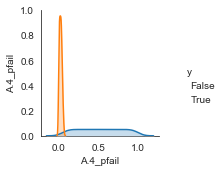

In [280]:
box1.show_pairs_scatter()
plt.show()

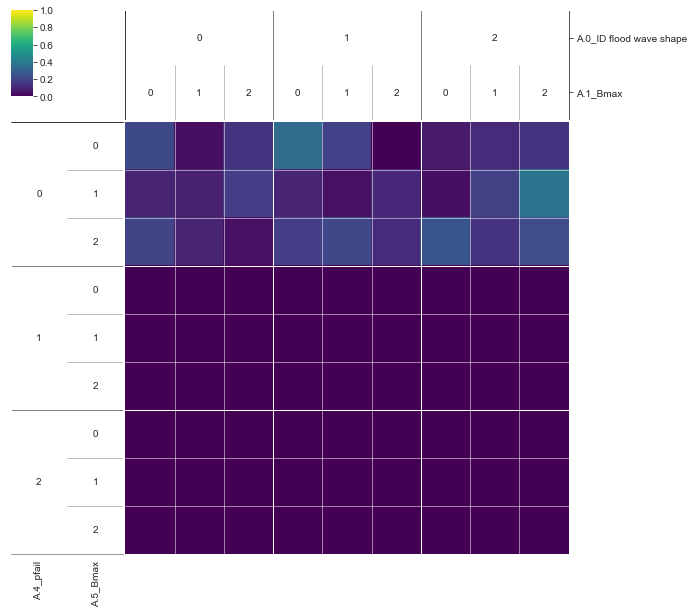

In [281]:
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

### Change model configuration

In [286]:
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation_anslysis(ID_PF, NR_STEPS)

In [291]:
# Make sure you are loading the updated file of 'problem_formulation_analysis'
# Change dike model levers since MORO gave us optimal policy and we applied 
# political constraints to it, some levers are fixed while
# we further optimize other levers. Change it accordingly

dike_model.levers = [IntegerParameter('0_RfR 0', 0, 1),
                     IntegerParameter('0_RfR 1', 0, 1),
                     IntegerParameter('1_RfR 0', 0, 1),
                     IntegerParameter('1_RfR 1', 0, 1),
                     IntegerParameter('4_RfR 0', 0, 1),
                     IntegerParameter('4_RfR 1', 0, 1),
                     IntegerParameter('A.1_DikeIncrease 1', 0, 10),
                     IntegerParameter('A.2_DikeIncrease 1', 0, 10),
                     IntegerParameter('A.3_DikeIncrease 1', 0, 10),
                     IntegerParameter('A.4_DikeIncrease 1', 0, 10),
                     IntegerParameter('A.5_DikeIncrease 1', 0, 10)]
# This constants are levers whose value is obtained after MORO and political constraints
dike_model.constants = [Constant('EWS_DaysToThreat', 0), 
                        Constant('A.1_DikeIncrease 0', 9),
                        Constant('A.2_DikeIncrease 0', 10),
                        Constant('A.3_DikeIncrease 0', 10),
                        Constant('A.4_DikeIncrease 0', 7), 
                        Constant('A.5_DikeIncrease 0', 6),
                        Constant('2_RfR 0', 1),
                        Constant('2_RfR 1', 1),
                        Constant('3_RfR 0', 1),
                        Constant('3_RfR 1', 1)]

# Outcomes we want to give to MORDM
dike_model.outcomes = [ScalarOutcome('A.4_Expected Annual Damage 0', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 0', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE)]

### Selecting best policy from PRIM and do further analysis for pathways

In [28]:
# Select the name of best policy and input it below. 
# In the test case it was 'Policy3'

results_pol3 = results_df2[results_df2['name2']== policy_selected]
results_pol3['tot_dam'] = results_pol3['A.4_Expected Annual Damage']+results_pol3['A.5_Expected Annual Damage']
results_pol3['tot_death'] = results_pol3['A.4_Expected Number of Deaths']+results_pol3['A.5_Expected Number of Deaths']
results_pol3_dam = results_pol3[['A.4_Expected Annual Damage','A.5_Expected Annual Damage','A.4_Expected Number of Deaths','A.5_Expected Number of Deaths',
                                 'tot_dam','tot_death']]
results_pol3_dam = results_pol3_dam.reset_index()
experiment_pol3 = experiment[experiment['policy']=='policy3']
experiment_pol3 = experiment_pol3.reset_index()
pol3_df = pd.concat([experiment_pol,results_pol3_dam],axis=1)
pol3_df = pol3_df.drop(['scenario','model','success'],axis=1) #Drop the unnecessary column

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
#Sort the scenarios for worst case of each objective and create separate dataframes for each sorted objective
pol3_df_a4_dam = pol3_df.sort_values(by=['A.4_Expected Annual Damage'], ascending=False)
pol3_df_a4_dam = pol3_df_a4_dam.reset_index()
pol3_df_a5_dam = pol3_df.sort_values(by=['A.5_Expected Annual Damage'], ascending=False)
pol3_df_a5_dam = pol3_df_a5_dam.reset_index()
pol3_df_tot_dam = pol3_df.sort_values(by=['tot_dam'], ascending=False)
pol3_df_tot_dam = pol3_df_tot_dam.reset_index()
pol3_df_a4_dea = pol3_df.sort_values(by=['A.4_Expected Number of Deaths'], ascending=False)
pol3_df_a4_dea = pol3_df_a4_dea.reset_index()
pol3_df_a5_dea = pol3_df.sort_values(by=['A.5_Expected Number of Deaths'], ascending=False)
pol3_df_a5_dea = pol3_df_a5_dea.reset_index()
pol3_df_tot_dea = pol3_df.sort_values(by=['tot_death'], ascending=False)
pol3_df_tot_dea = pol3_df_tot_dea.reset_index()

In [30]:
# There will be 6 scenarios for 6 objective, now we create a data frame of length 6 
# for this 6 scenarios,we select the 100th value because
# values in dataframe above that have pfail at A4 < 0.05 
# which means dike at A4 will fail and the only way to avoid deaths is to implement EWS

scenario1 = pol3_df_a4_dam.iloc[0]
scenario2 = pol3_df_a5_dam.iloc[0]
scenario3 = pol3_df_tot_dam.iloc[0]
scenario4 = pol3_df_a4_dea.iloc[0]
scenario5 = pol3_df_a5_dea.iloc[0]
scenario6 = pol3_df_tot_dea.iloc[0]
scenarios = pd.concat([scenario1,scenario2,scenario3,scenario4,scenario5,scenario6],axis=1)
scenarios_tr = scenarios.T
scenarios_tr

,level_0,index,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,policy,index,A.4_Expected Annual Damage,A.5_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,tot_dam,tot_death
0,363,4363,0,99.7716,1,0.0966482,41.8362,1.5,0.377219,331.922,...,6,0,policy3,4363,2.66709e+07,0,0.00846608,0,2.66709e+07,0.00846608
0,1174,5174,46,76.0156,10,0.300171,112.55,10,0.21939,54.6085,...,6,0,policy3,5174,0,1.89803e+08,0,0.152677,1.89803e+08,0.152677
0,1174,5174,46,76.0156,10,0.300171,112.55,10,0.21939,54.6085,...,6,0,policy3,5174,0,1.89803e+08,0,0.152677,1.89803e+08,0.152677
0,363,4363,0,99.7716,1,0.0966482,41.8362,1.5,0.377219,331.922,...,6,0,policy3,4363,2.66709e+07,0,0.00846608,0,2.66709e+07,0.00846608
0,1174,5174,46,76.0156,10,0.300171,112.55,10,0.21939,54.6085,...,6,0,policy3,5174,0,1.89803e+08,0,0.152677,1.89803e+08,0.152677
0,1174,5174,46,76.0156,10,0.300171,112.55,10,0.21939,54.6085,...,6,0,policy3,5174,0,1.89803e+08,0,0.152677,1.89803e+08,0.152677


In [31]:
# Convert the scenarios to dictionary. You need to visually inspect the dataframe scenarios_unc
# to select worst scenario at locations 4 and 5 in my case they were the 4th and 5th rows, 
# hence 3rd and 4th indices

scenarios_unc = scenarios_tr.iloc[:,1:19] 
uncertainty1 = scenarios_unc.iloc[0].to_dict()
uncertainty_loc4= Scenario('uncertainty1', **uncertainty1)
uncertainty2 = scenarios_unc.iloc[1].to_dict()
uncertainty_loc5= Scenario('uncertainty2', **uncertainty2)

### All policies

In [32]:
policy0 = {'DikeIncrease': 10, 'DaysToThreat': 0, 'RfR': 1}
ref_policy = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    ref_policy.update({key.name: policy0[s]})
ref_policy0 = Policy('baseline', **ref_policy) # policy0

In [37]:
results = perform_experiments(dike_model, 
                              scenarios = uncertainty_loc5, # the same 1,000 sampled scenarios
                              policies = ref_policy0)    # zero policy

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


In [38]:
results[1]

{'Expected Annual Damage': array([20761411.44465538]),
 'Dike Investment Costs': array([1.3831049e+09]),
 'RfR Investment Costs': array([2.1312e+09]),
 'Evacuation Costs': array([0.]),
 'Expected Number of Deaths': array([0.01765539])}

### Run MORDM on 2 selected worst case scenarios

In [282]:
nfe_MORDM = 2500
epsilon = [1000000, 1000000, 1000000, 0.001, 0.001] 
convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0,0], 
                                   maximum=[1e8,1e8,1e8,1e8,10]),
                       EpsilonProgress()]

In [284]:
'''LOAD RESULTS FROM
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.optimize(nfe=nfe_MORDM, 
#                                  searchover='levers',
#                                  epsilons=epsilon,
#                                  convergence=convergence_metrics,
#                                  reference=uncertainty_loc4, convergence_freq=10)
#
'''
results = load_results('./results/scenario_loc4 MORDMruns_worst case scenario.tar.gz')
outcomes, convergence = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\scenario_loc4 MORDMruns_worst case scenario.tar.gz


Text(0.5, 0, 'number of function evaluations')

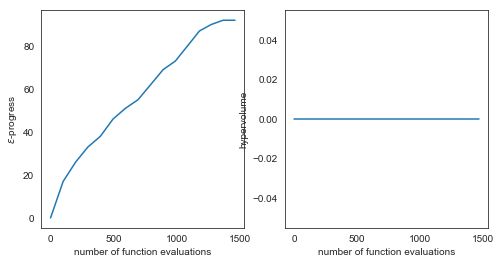

In [285]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')